In [4]:
%matplotlib inline
import math
from decimal import *
import numpy as np # linear algebra
import pandas as pd # read_csv and such
import matplotlib.pyplot as plt # plotting and such
from geopy.distance import vincenty # calculate distance between locations
from io import StringIO # convert strings to buffers or something like that.
import seaborn as sns

pd.options.display.max_columns = 999

### Get the data and start messing with it

In [5]:
# the path to our flight + weather combined data set
flights_weather_path = '../data/flights_weather.csv'

In [6]:
flights_weather_df = pd.read_csv(flights_weather_path)
flights_weather_df.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


# Correlation Analysis of 2015 Flight Delays and Weather Data
---
We want to do a simple correlation analysis of the combined flight + weather dataset, and produce a heatmap of the variable correlaitons.

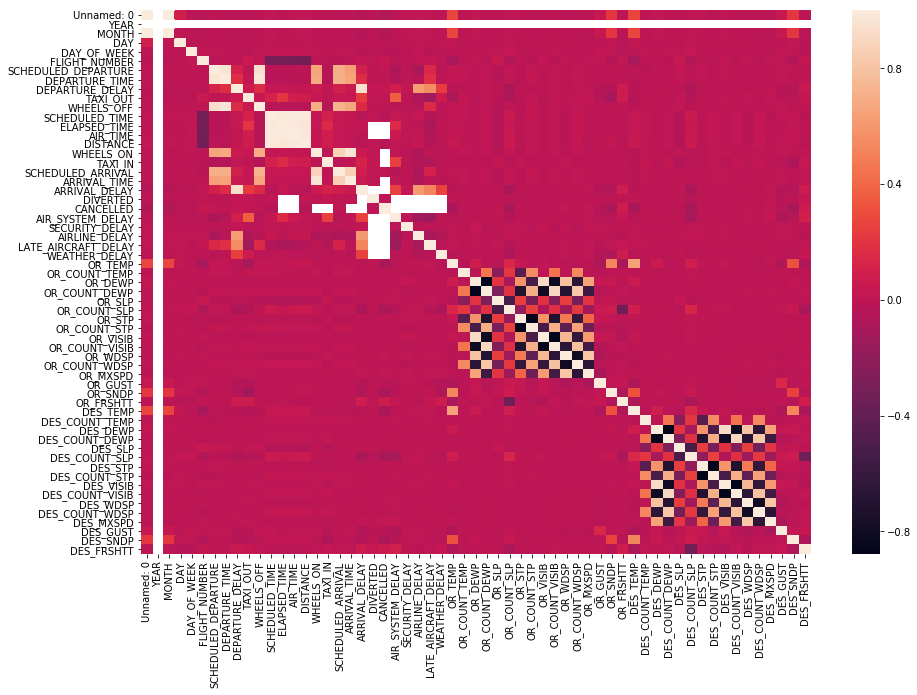

In [7]:
corr = flights_weather_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           ax=ax)